## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

## Reading Epochs and preprocessing

In [146]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.resample(600).crop(0, None)
info = epochs.info

## Create a dataset containig epoched data

In [3]:
dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
del raw, epochs, epochs_list

## Split the dataset into train and test sets

In [4]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Create model, inheriting from BaseModel class
***
This model has a spatial filtering layer and temporal filtering layer (the same as FIR filter) with a choice of each n-th output and a fully connected layer for predicting

You can simply import this model like that: ```from deepmeg.models.interpretable import LFCNN```

In this example, the code for the neural network is written entirely for demonstration. If you are not interested in the details of implementing models, just skip this
***

In [5]:
class LFCNN(BaseModel):
    """
    A 1-dimensional convolutional neural network for the Linear Finite-impulse-response Convolutional Neural Network (LF-CNN) [1].

    Args:
        n_channels (int): Number of channels in the input data. Input data shape supposed to be: (N batches, N channels, N times).
        n_latent (int): Number of latent features in the unmixing layer.
        n_times (int): Length of the time axis of the input data.
        filter_size (int): Size of the FIR filters in the temporal convolutional layer.
        pool_factor (int): Factor to reduce the length of the time axis by selecting every n-th output.
        n_outputs (int): Number of outputs of the final fully connected layer.

    Attributes:
        pool_factor (int): Factor to reduce the length of the time axis by selecting every n-th output.
        unmixing_layer (nn.Module): 1D depthwise convolutional layer for spatial unmixing (filtering) the input tensor.
        temp_conv (nn.Module): 1D temporal convolutional layer for temporal filtering (FIR-filter-like) the spatially filtered tensor.
        fc_layer (nn.Module): Final fully connected layer for producing the outputs.

    References:
        [1] Zubarev, I., Zetter, R., Halme, H. L., & Parkkonen, L. (2019).
            Adaptive neural network classifier for decoding MEG signals.
            NeuroImage, 197, 425-434. https://doi.org/10.1016/j.neuroimage.2019.04.068
    """

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, n_channels, n_times).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, n_outputs).
        """
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [6]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

## Compile the model

In [7]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

## Training the model

  0%|          | 0/150 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.7381   |    binary_accuracy_train:  0.4709   |    loss_val:  0.7250   |    binary_accuracy_val:  0.5254
Epoch 1:  loss_train:  0.7146   |    binary_accuracy_train:  0.5693   |    loss_val:  0.7043   |    binary_accuracy_val:  0.6024
Epoch 2:  loss_train:  0.6910   |    binary_accuracy_train:  0.6752   |    loss_val:  0.6813   |    binary_accuracy_val:  0.6870
Epoch 3:  loss_train:  0.6652   |    binary_accuracy_train:  0.7514   |    loss_val:  0.6554   |    binary_accuracy_val:  0.7658
Epoch 4:  loss_train:  0.6370   |    binary_accuracy_train:  0.8057   |    loss_val:  0.6266   |    binary_accuracy_val:  0.8063
Epoch 5:  loss_train:  0.6062   |    binary_accuracy_train:  0.8336   |    loss_val:  0.5951   |    binary_accuracy_val:  0.8303
Epoch 6:  loss_train:  0.5733   |    binary_accuracy_train:  0.8471   |    loss_val:  0.5614   |    binary_accuracy_val:  0.8407
Epoch 7:  loss_train:  0.5391   |    binary_accuracy_train:  0.8537   |    loss_val:  0.5269   | 

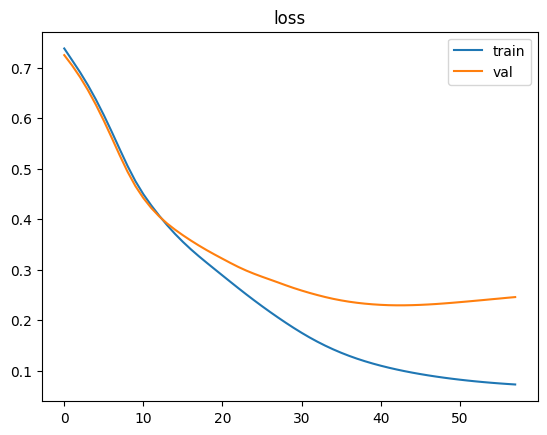

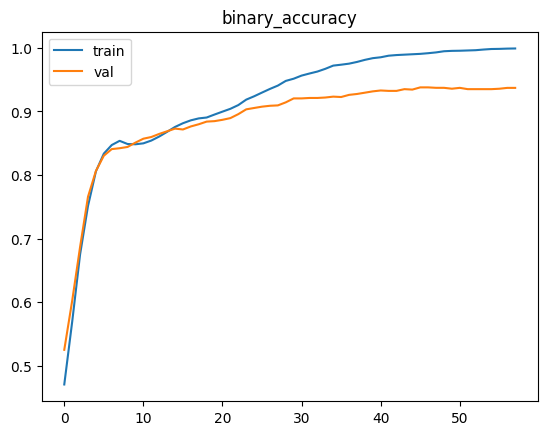

In [8]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [9]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.13067944686521182
train_binary_accuracy: 0.9763767448338595
loss: 0.2365092012015256
binary_accuracy: 0.9269480542703108


## Make a prediction

#### Take a random sample from the test set

In [10]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 50


#### Make a prediction, print the predicted value and the actual label

In [11]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction: -2.79 | -10.68 | -6.53 | -3.21 |  2.21 | -5.78 | -9.62 | -5.43
Actual:      0.0  |  0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0  |  0.0 


## Model interpretation

***
We can interpret LFCNN in spatial and temporal domains

You can simply import this model interpreter like that: ```from deepmeg.interpreters import LFCNNInterpreter```

In this example, the code for the neural network interpreter is written entirely for demonstration. If you are not interested in the details of implementing model interpretations, just skip this

***

In [125]:
class LFCNNInterpreter:
    """
        Initialize LFCNNInterpreter object.

        Parameters:
            model (LFCNN): Trained LFCNN model.
            dataset (Dataset): Data used to train the LFCNN model.
            info (mne.Info): Information about recordings, typically contained in the "info" property of the corresponding instance (E.g. epochs.info).

        """
    def __init__(self, model: LFCNN, dataset: Dataset, info: mne.Info):
        self.model = model
        self.dataset = dataset
        self.info = info
        self._latent_sources = None
        self._latent_sources_filtered = None
        self._spatial_patterns = None
        self._spatial_filters = None
        self._frequency_range = None
        self._filter_inputs = None
        self._filter_responses = None
        self._filter_outputs = None
        self._filter_patterns = None
        self._branchwise_loss = None

    @torch.no_grad()
    def compute_patterns(self):
        """
        Compute the spatial patterns and filters of the LFCNN model.
        Spatial patterns are achieved from spatial filters with following formula:

            A = K_x * W * K_s

        Where A is matrix of spatial patterns, W is a matrix of spatial filters (model.unmixing_layer.weight, biases can be omitted due to linearity),
        K_x and K_s are covariance matrices of input data and latent sources respectively [1].
        According to [2], K_x should also be filtered with weights from temporal filtering layer (model.temp_conv)

        Returns:
            tuple: Tuple of two numpy arrays, containing the spatial patterns and filters.

        References:
            [1] Haufe, S., Meinecke, F., Görgen, K., Dähne, S., Haynes, J. D., Blankertz, B., & Bießmann, F. (2014).
                On the interpretation of weight vectors of linear models in multivariate neuroimaging.
                NeuroImage, 87, 96-110. https://doi.org/10.1016/j.neuroimage.2013.10.067
            [2] Petrosyan, A., Sinkin, M., Lebedev, M., & Ossadtchi, A. (2021).
                Decoding and interpreting cortical signals with a compact convolutional neural network.
                Journal of Neural Engineering, 18(2), 026019. https://doi.org/10.1088/1741-2552/abe20e
        """
        x, y = next(iter(DataLoader(self.dataset, len(self.dataset))))
        x_flatten = x.reshape(x.shape[1], x.shape[0]*x.shape[-1])
        latent_sources = self.model.unmixing_layer(x)
        latent_sources_filtered = self.model.temp_conv(latent_sources)
        latent_sources_flatten = latent_sources_filtered.reshape(latent_sources.shape[1], latent_sources.shape[0]*latent_sources.shape[-1])
        self._latent_sources = latent_sources.numpy()
        self._latent_sources_filtered = latent_sources_filtered.numpy()
        unmixing_matrix = model.unmixing_layer.weight.numpy()[:, :, 0]
        filters = unmixing_matrix.T
        # covariance of latent_sources should aim to I, due to linear independance
        x = x.permute(1, 0, -1)
        x_flatten = x.reshape(x.shape[0], x.shape[1]*x.shape[-1])
        patterns = list()
        for comp_num in range(len(model.unmixing_layer.weight)):
            x_filt_flatten = torch.zeros_like(x_flatten)

            for ch_num in range(x.shape[0]):

                x_filt_flatten[ch_num] = torch.nn.functional.conv1d(
                    torch.unsqueeze(x_flatten[ch_num], 0),
                    torch.unsqueeze(model.temp_conv.weight[comp_num].detach(), 0),
                    padding='same'
                )
            patterns.append(torch.cov(x_filt_flatten)@model.unmixing_layer.weight[comp_num])

        patterns = torch.squeeze(torch.stack(patterns, 1))@torch.cov(latent_sources_flatten)

        return patterns.numpy(), filters

    @torch.no_grad()
    def compute_branchwise_loss(self):
        """
        This method computes the branchwise loss for each branch of LF-CNN (branch consits of two connected spatial and temporal filters).
        It computes loss of each branch by subtracting loss of original model from loss of the same model without nth branch.
        It is one of the easiest ways to estimate relevance of the branch.

        Returns:
            numpy.ndarray: A 1-dimensional numpy array of shape (n_latent, ) where n_latent is the number of branches in the model.
        """
        loader = DataLoader(self.dataset, len(self.dataset))
        base_loss = self.model.evaluate(loader)['loss']
        n_latent = self.model.unmixing_layer.weight.shape[0]

        losses = list()
        for i in range(n_latent):
            branch_unmixing_weights_original = deepcopy(self.model.unmixing_layer.weight[i, :, :])
            branch_unmixing_bias_original = deepcopy(self.model.unmixing_layer.bias[i])
            branch_temp_conv_bias_original = deepcopy(self.model.temp_conv.bias[i])
            self.model.unmixing_layer.weight[i, :, :] = 0
            self.model.unmixing_layer.bias[i] = 0
            self.model.temp_conv.bias[i] = 0
            losses.append(self.model.evaluate(loader)['loss'])
            self.model.unmixing_layer.weight[i, :, :] = branch_unmixing_weights_original
            self.model.unmixing_layer.bias[i] = branch_unmixing_bias_original
            self.model.temp_conv.bias[i] = branch_temp_conv_bias_original
        return base_loss - np.array(losses)

    @torch.no_grad()
    def compute_specta(self):
        """
        Compute the spectral parameters of temporal filters (model.temp_conv.weight, biases can be omitted due to linearity).

        Returns:
            frange (ndarray): The frequency range for the power spectral density.
            finputs (list): The power spectral density of the latent sources (spatially filtered data).
            fresponces (list): The absolute value of the frequency response of the filters.
                (FFT of the dephased Wiener filter).
            fpatterns (list): The product of the power spectral density and the absolute value of the frequency response.
                (spectral power density of the signal at the input of the Wiener optimal filter).
            foutputs (list): The product of the power spectral density and the squared magnitude of the frequency response.
                (spectral power density of the signal at the output of the digital filter).

        """
        filters = torch.squeeze(self.model.temp_conv.weight).detach().numpy()
        finputs, fresponces, fpatterns, foutputs = list(), list(), list(), list()
        frange = None

        for branch_num in range(self.latent_sources.shape[1]):
            lat_tc = self.latent_sources[:, branch_num, :]
            kern = filters[branch_num]
            frange, psd = sp.signal.welch(lat_tc, fs=self.info['sfreq'], nperseg=len(lat_tc)-1)
            _, h = sp.signal.freqz(kern, 1, worN=len(lat_tc)//2)
            finputs.append(psd)
            fresponces.append(np.abs(h))
            fpatterns.append(finputs[-1]*fresponces[-1])
            foutputs.append(finputs[-1]*h*np.conj(h))

        return frange, finputs, fresponces, foutputs, fpatterns

    def __validate_spatial(self):
        """
        Computes the spatial patterns and filters for the given data.
        If the spatial patterns or filters are already computed and stored, this step is skipped.
        """
        if self._spatial_patterns is None or self._spatial_filters is None:
            self._spatial_patterns, self._spatial_filters = self.compute_patterns()

    def __validate_spectral(self):
        """
        This method validates the spectal properties of the data. If the frequency range, filter inputs, filter responses,
            filter outputs, or filter patterns have not been computed, the method calls compute_specta to compute them.
        """
        if self._frequency_range is None\
            or self._filter_inputs is None\
            or self._filter_responses is None\
            or self._filter_outputs is None\
            or self._filter_patterns is None:
            self._frequency_range,\
                self._filter_inputs,\
                self._filter_responses,\
                self._filter_outputs,\
                self._filter_patterns = self.compute_specta()

    def __validate_branchwise_estimate(self):
        """
        Validates the branchwise loss by computing it if it has not been computed previously.

        The `_branchwise_loss` attribute is set to the result of the `compute_branchwise_loss` method.

        """
        if self._branchwise_loss is None:
            self._branchwise_loss = self.compute_branchwise_loss()

    @property
    def latent_sources(self):
        """
        Get the latent sources.

        Returns:
            torch.Tensor: The latent sources with shape (n_epochs, n_latent, n_times).
        """
        # shape: n_epochs, n_latent, n_times
        self.__validate_spatial()
        return self._latent_sources
    @property
    def latent_sources_filtered(self):
        """
        Get the filtered latent sources.

        Returns:
            torch.Tensor: The filtered latent sources with shape (n_epochs, n_latent, n_times).
        """
        self.__validate_spatial()
        return self._latent_sources_filtered
    @property
    def spatial_patterns(self):
        """
        Get the spatial patterns.

        Returns:
            torch.Tensor: The spatial patterns with shape (n_channels, n_latent).
        """
        # shape: n_channels, n_latent
        self.__validate_spatial()
        return self._spatial_patterns
    @property
    def spatial_filters(self):
        """
        Get the spatial filters.

        Returns:
            torch.Tensor: The spatial filters with shape (n_channels, n_latent).
        """
        self.__validate_spatial()
        return self._spatial_filters
    @property
    def frequency_range(self):
        """
        Get the frequency range.

        Returns:
            numpy.ndarray: The frequency range for spectrum.
        """
        self.__validate_spectral()
        return self._frequency_range
    @property
    def filter_inputs(self):
        """
        Get the temporal filters inputs.

        Returns:
            List[numpy.ndarray]: The filters inputs.
        """
        self.__validate_spectral()
        return self._filter_inputs
    @property
    def filter_responses(self):
        """
        Get the temporal filters responses.

        Returns:
            List[numpy.ndarray]: The filters responses.
        """
        self.__validate_spectral()
        return self._filter_responses
    @property
    def filter_outputs(self):
        """
        Get the temporal filters outputs.

        Returns:
            List[numpy.ndarray]: The filters outputs.
        """
        self.__validate_spectral()
        return self._filter_outputs
    @property
    def filter_patterns(self):
        """
        Get the temporal filters patterns.

        Returns:
            List[numpy.ndarray]: The filtering patterns.
        """
        self.__validate_spectral()
        return self._filter_patterns
    @property
    def branchwise_loss(self):
        """
        Get the branchwise loss.

        Returns:
            List[float]: The branchwise loss.
        """
        self.__validate_branchwise_estimate()
        return self._branchwise_loss

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure:
        """
        Plot the branchwise information for a specific branch of the model.

        Parameters:
        branch_num (int): the branch number to plot (order of branches is determined by `branchwise_loss`).
        spec_plot_elems (List[str]): a list of plot elements to include in the spectrum plot.
        title (str): optional title for the plot.

        Returns:
        matplotlib.figure.Figure: the plot.

        """
        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)[::-1]
        patterns_sorted = self.spatial_patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        times = np.arange(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], 1/self.info['sfreq'])
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=0.25
        )
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )
        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Time, s')
        ax2.legend(['spatially filtered', 'temporally filtered'], loc='upper right')

        spec_legend = list()
        x = np.arange(0, self.frequency_range[-1], .1)

        interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

        plt.xlim(0, 100)
        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                linewidth=.75
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
            data -= data.min()
            ax3.plot(
                x,
                interp_cubic(data),
                alpha=.75,
                linestyle='--'
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('pattern')
            data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax3.legend(spec_legend, loc='upper right')
        ax3.set_ylabel('Amplitude, zscore')
        ax3.set_xlabel('Frequency, Hz')
        ax3.set_xlim(0, 100)

        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
            cmap='Blues'
        )
        if title:
            fig.suptitle(f'Branch {branch_num}')

        fig.tight_layout()

        return fig

In [126]:
interpreter = LFCNNInterpreter(model, test, info)

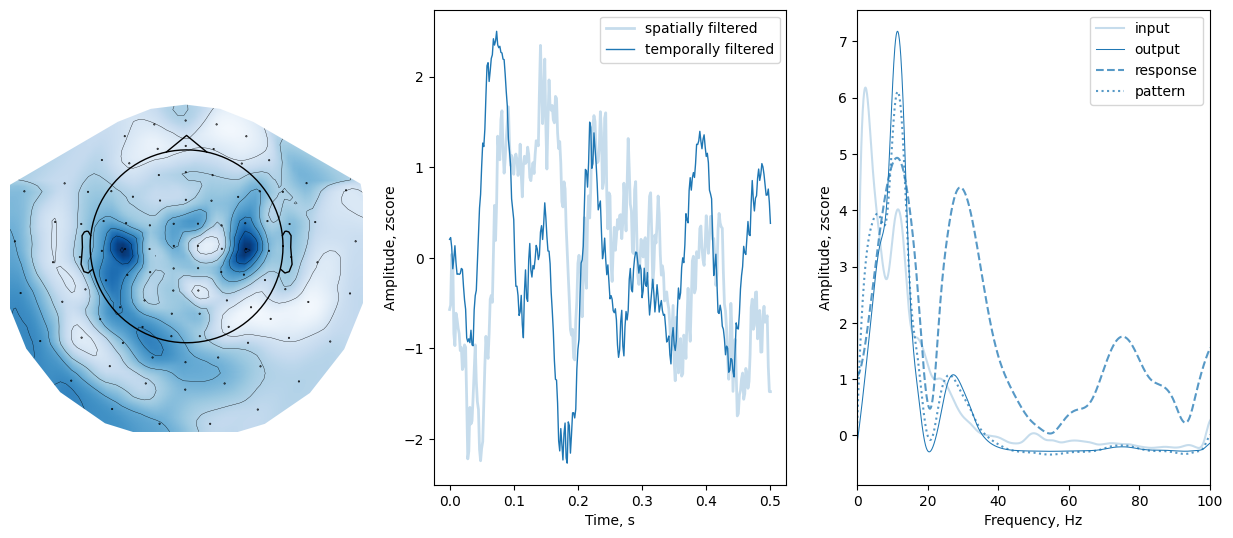

In [131]:
fig = interpreter.plot_branch(0, ['input', 'output', 'response', 'pattern'])